# Import Required Classes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns

sns.set_style("darkgrid")

sys.path.append('../src')

In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/notebooks


In [3]:
from XGBoostBaselineClassifier import XGBoostBaselineClassifier
from XGBoostTuner import XGBoostTunerCV
from DiskIO import DiskIO

/Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/Ass2_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Run Baseline XGBoost Classifier

In [4]:
baseline = XGBoostBaselineClassifier()
baseline.load_and_prepare_data()

[DiskIO] Using base directory: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models


In [5]:
baseline.train()

Classification Report:
Accuracy: 98.28%
Recall: 97.76%
Specificity: 99.63%
PPV: 98.13%
NPV: 99.64%
F1: 97.94%


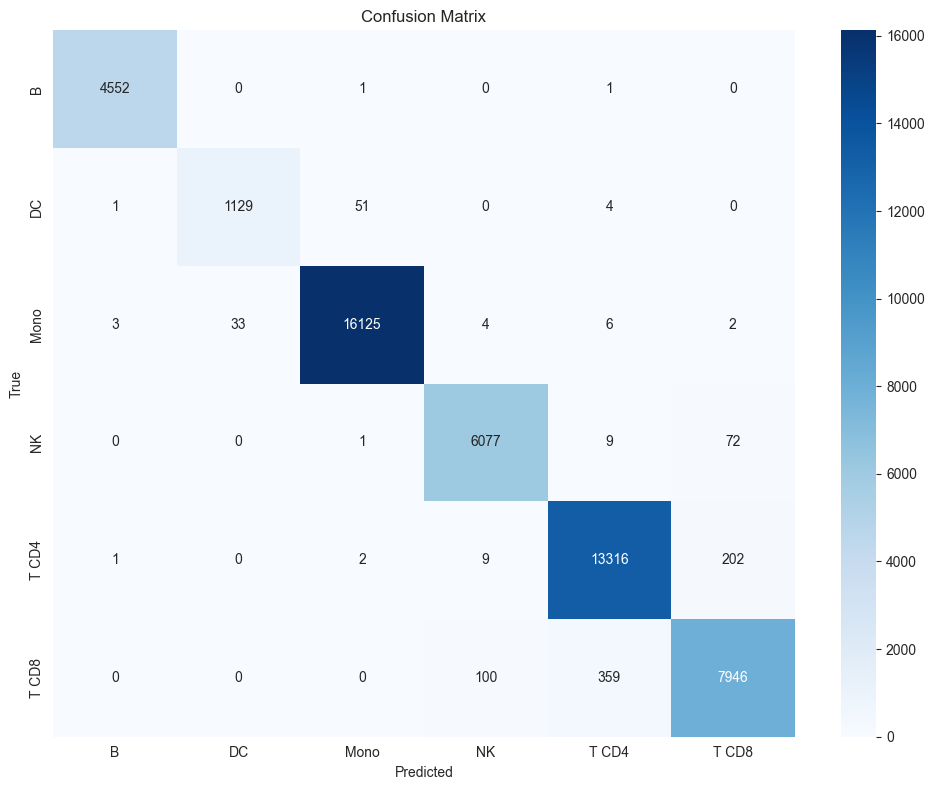

In [6]:
# Unpack the evaluation results: (train_results, test_results)
report, cm, stats = baseline.evaluate()

print("Classification Report:")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
baseline.plot_confusion_matrix(cm)

In [7]:
# Remove 'accuracy' because it's not a dict
accuracy = report.pop('accuracy', None)

# Convert to DataFrame
df_report = pd.DataFrame(report).T  # Transpose to have labels as rows

# Round float values
df_report = df_report.round(3)

# Add accuracy if present
if accuracy is not None:
    df_report.loc['accuracy'] = [None] * (df_report.shape[1] - 1) + [round(accuracy, 3)]

df_report

,precision,recall,f1-score,support
B,0.999,1.000,0.999,4554.000
DC,0.972,0.953,0.962,1185.000
Mono,0.997,0.997,0.997,16173.000
NK,0.982,0.987,0.984,6159.000
T CD4,0.972,0.984,0.978,13530.000
T CD8,0.966,0.945,0.956,8405.000
macro avg,0.981,0.978,0.979,50006.000
weighted avg,0.983,0.983,0.983,50006.000
accuracy,NaN,NaN,NaN,0.983


In [8]:
model_name = 'baseline'
baseline.save_model(pipeline=baseline.pipeline, label_encoder=baseline.label_encoder)

[DiskIO] Saved to: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models/XGBoost.pkl
[DiskIO] Saved to: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models/label_encoder.pkl


# Optuna Tuning for XGBoost - Nested CV

In [9]:
# Initialize and tune
tuner = XGBoostTunerCV(n_trials=30)
tuner.tune_hyperparameters()

[DiskIO] Using base directory: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models
[DiskIO] Using base directory: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models


[I 2025-06-25 21:40:07,406] A new study created in memory with name: no-name-50663ccf-87dc-479c-8b4f-4782fb651931
[I 2025-06-25 21:40:19,361] Trial 0 finished with value: 0.9820918411781685 and parameters: {'n_estimators': 198, 'max_depth': 6, 'learning_rate': 0.29446580283976587, 'min_child_weight': 4, 'gamma': 0.6475858310832371, 'subsample': 0.8221892407754298, 'colsample_bytree': 0.9142740136742586, 'reg_alpha': 0.24725239137106114, 'reg_lambda': 3.3357231445021798}. Best is trial 0 with value: 0.9820918411781685.
[I 2025-06-25 21:40:30,048] Trial 1 finished with value: 0.9813269703709092 and parameters: {'n_estimators': 179, 'max_depth': 3, 'learning_rate': 0.07076388609545234, 'min_child_weight': 10, 'gamma': 0.6453975437457607, 'subsample': 0.8841110113220477, 'colsample_bytree': 0.6300009662222553, 'reg_alpha': 0.5193853142649038, 'reg_lambda': 1.2669334266248429}. Best is trial 0 with value: 0.9820918411781685.
[I 2025-06-25 21:40:34,031] Trial 2 finished with value: 0.9797974

Best Parameters Found:
{'n_estimators': 183, 'max_depth': 5, 'learning_rate': 0.1406869202121568, 'min_child_weight': 5, 'gamma': 0.43041964689105416, 'subsample': 0.9465192013877911, 'colsample_bytree': 0.8089143269911357, 'reg_alpha': 0.8127896133411804, 'reg_lambda': 4.05795334884265}


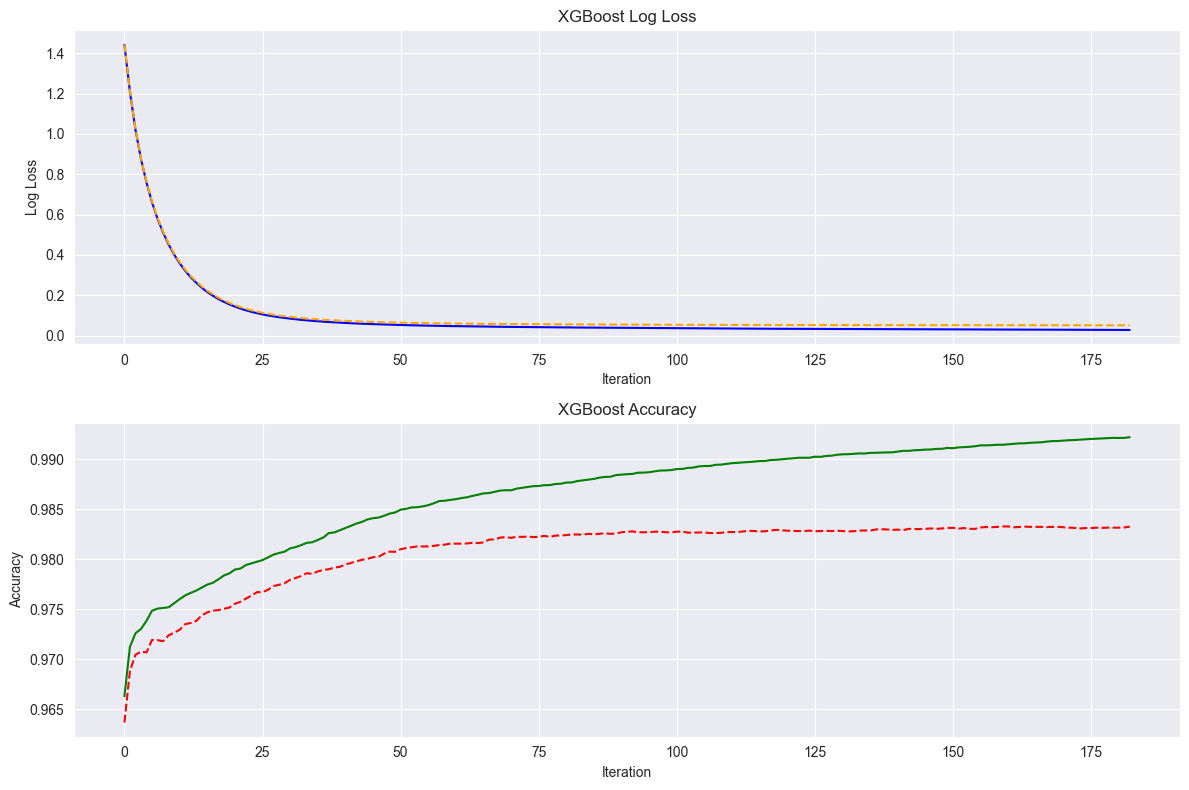

In [10]:
# Print best parameters
print("Best Parameters Found:")
print(tuner.best_params)

# Train final model
tuner.train_final_model()

# Plot learning curve
tuner.plot_learning_curve()

In [11]:
# Train on full Hao datasets and save final model
tuner.train_and_save_final_model_on_full_data(suffix='final')

[DiskIO] Saved to: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models/XGBoost_final.pkl
[DiskIO] Saved to: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models/label_encoder_final.pkl


In [12]:
# Evaluate on external data (Kotliarov dataset)
report, cm, stats = tuner.evaluate_on_external_testset("../data/kotliarov.csv", suffix='final')

[DiskIO] Loading from: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models/XGBoost_final.pkl
[WARNING] Unseen labels: {'T unconv', 'HSC'}


In [13]:
# Print results

# Remove 'accuracy' because it's not a dict
accuracy = report.pop('accuracy', None)

# Convert to DataFrame
df_report = pd.DataFrame(report).T  # Transpose to have labels as rows

# Round float values
df_report = df_report.round(3)

# Add accuracy if present
if accuracy is not None:
    df_report.loc['accuracy'] = [None] * (df_report.shape[1] - 1) + [round(accuracy, 3)]

df_report

,precision,recall,f1-score,support
B,0.997,0.967,0.982,5828.000
DC,0.936,0.887,0.911,646.000
Mono,0.981,0.989,0.985,7851.000
NK,0.934,0.967,0.950,4722.000
T CD4,0.912,0.966,0.938,20119.000
T CD8,0.928,0.813,0.866,9780.000
macro avg,0.948,0.931,0.939,48946.000
weighted avg,0.939,0.938,0.937,48946.000
accuracy,NaN,NaN,NaN,0.938


Tuned Model - Classification Report:
Accuracy: 93.81%
Recall: 93.13%
Specificity: 98.44%
PPV: 94.8%
NPV: 98.63%
F1: 93.87%


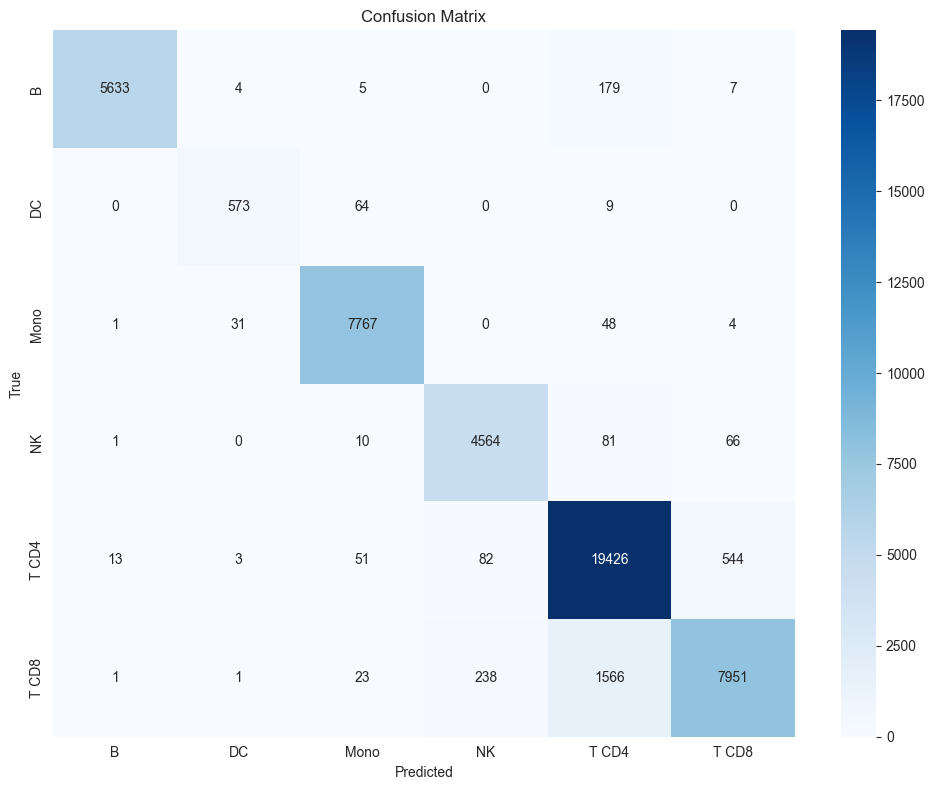

In [14]:
# Print stats
print("Tuned Model - Classification Report:")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
tuner.plot_confusion_matrix(cm)

# Baseline vs Tuned

In [15]:
# Load training set to get feature names in correct order
hao = pd.read_csv("../data/hao.csv", index_col=0)
expected_features = hao.drop(columns=["label"]).columns

In [16]:
# Load Kotliarov test data (same format as hao.csv)
kotliarov = pd.read_csv("../data/kotliarov.csv", index_col=0)
X_kot = kotliarov.drop(columns=["label"])
y_kot = kotliarov["label"]

# Align Kotliarov features to match training features
X_kot_aligned = X_kot[expected_features]

In [19]:
io = DiskIO("../models")

baseline_model = io.load("XGBoost")
tuned_model = io.load("XGBoost", "final")
label_encoder = io.load("label_encoder_final")

[DiskIO] Using base directory: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models
[DiskIO] Loading from: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models/XGBoost.pkl
[DiskIO] Loading from: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models/XGBoost_final.pkl
[DiskIO] Loading from: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models/label_encoder_final.pkl


In [20]:
# Get the list of class labels the encoder was originally trained on
known_labels = label_encoder.classes_

# Create a boolean mask to keep only samples with labels the encoder recognizes
# This is necessary to avoid transforming labels that were not seen during training (would raise an error)
valid_mask = y_kot.isin(known_labels)

# Align test features with training feature order and keep only valid rows
# Note: 'expected_features' must match the training set columns exactly
X_kot_aligned = X_kot[valid_mask][expected_features]

# Filter the test labels to include only valid rows (i.e., rows with known labels)
y_kot_filtered = y_kot[valid_mask]

# Transform the filtered string labels into numerical form using the trained encoder
y_kot_encoded = label_encoder.transform(y_kot_filtered)

In [21]:
from MetricsCore import MetricsCalculator

metrics_calculator = MetricsCalculator()

baseline_metrics = metrics_calculator.compute_from_model(baseline_model, X_kot_aligned, y_kot_encoded)
tuned_metrics = metrics_calculator.compute_from_model(tuned_model, X_kot_aligned, y_kot_encoded)

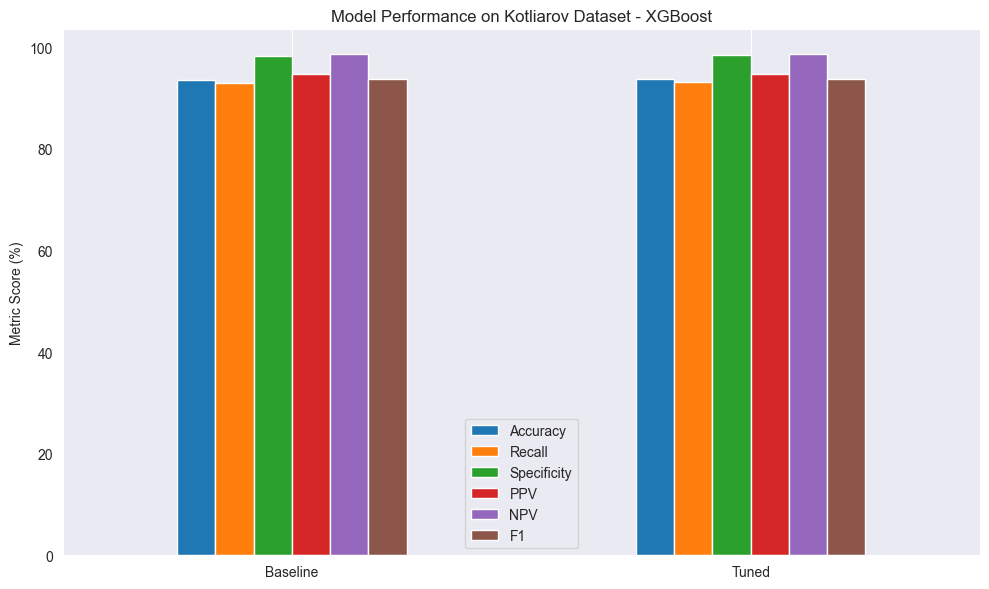

In [22]:
# Create DataFrame
df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Tuned': tuned_metrics
})

df.T.plot(kind='bar', figsize=(10, 6), rot=0)
plt.ylabel("Metric Score (%)")
plt.title("Model Performance on Kotliarov Dataset - XGBoost")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [23]:
df

,Baseline,Tuned
Accuracy,93.66,93.81
Recall,92.90,93.13
Specificity,98.40,98.44
PPV,94.81,94.80
NPV,98.61,98.63
F1,93.76,93.87


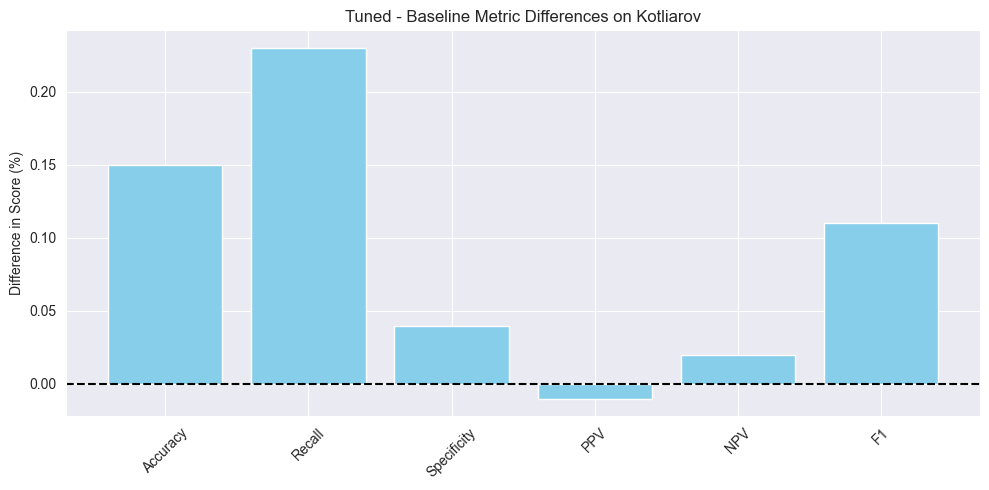

In [24]:
metrics = list(baseline_metrics.keys())
baseline_values = [baseline_metrics[m] for m in metrics]
tuned_values = [tuned_metrics[m] for m in metrics]
diff = [t - b for t, b in zip(tuned_values, baseline_values)]

# Extract the list of metric names from the baseline results (e.g., Accuracy, F1, etc.)
metrics = list(baseline_metrics.keys())

# Collect metric values for baseline and tuned models in the same order
baseline_values = [baseline_metrics[m] for m in metrics]
tuned_values = [tuned_metrics[m] for m in metrics]

# Compute the difference in performance for each metric (Tuned - Baseline)
# This helps identify which metrics improved and by how much
diff = [t - b for t, b in zip(tuned_values, baseline_values)]

plt.figure(figsize=(10, 5))
bars = plt.bar(metrics, diff, color='skyblue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Tuned - Baseline Metric Differences on Kotliarov")
plt.ylabel("Difference in Score (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Predict labels on the Kotliarov test set using both baseline and tuned models
baseline_preds = baseline_model.predict(X_kot_aligned)
tuned_preds = tuned_model.predict(X_kot_aligned)

# Calculate the percentage of samples for which both models made the same prediction
agreement = np.mean(baseline_preds == tuned_preds)

# Display model agreement in percentage format
print(f"The two models agree on {agreement * 100:.2f}% of predictions.")

The two models agree on 98.61% of predictions.


# Interpretation - SHAP

In [26]:
import shap

# Prepare background data for SHAP explainer
background_data = tuned_model.named_steps["scaler"].transform(X_kot_aligned.sample(100, random_state=42))

# Get the XGBoost model from the pipeline
xgb_model = tuned_model.named_steps["model"]

# Create SHAP explainer for the tuned model
explainer = shap.Explainer(xgb_model, background_data)

# Compute SHAP values for the (scaled) test set
X_kot_scaled = tuned_model.named_steps["scaler"].transform(X_kot_aligned)
shap_values = explainer(X_kot_scaled)

100%|===================| 293576/293676 [40:46<00:00]        

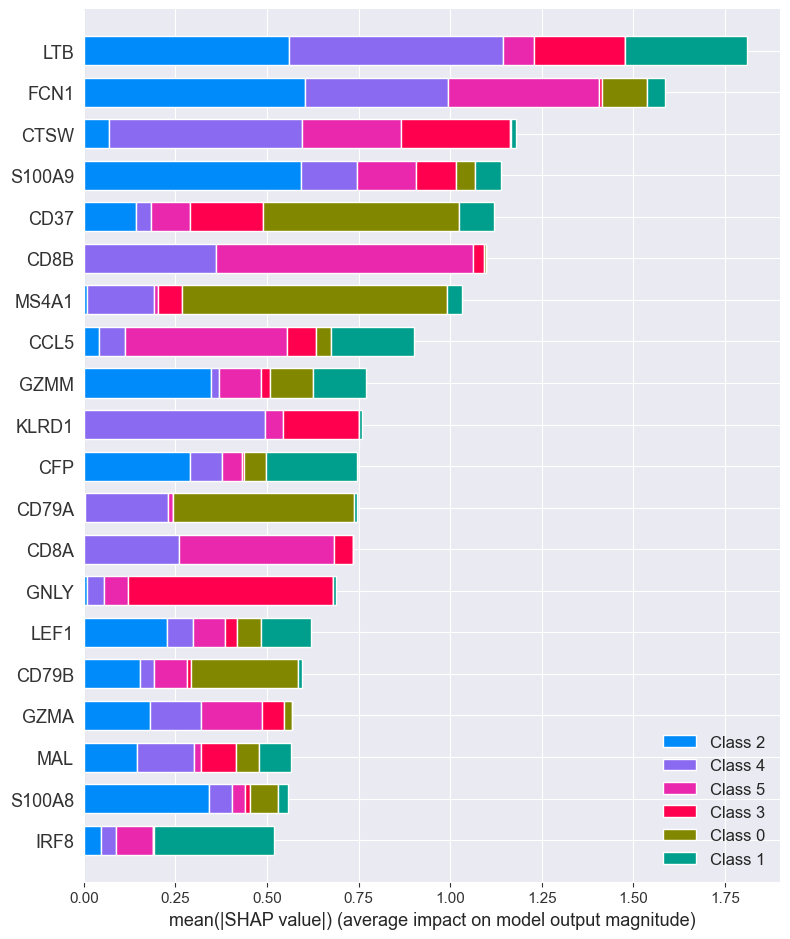

In [27]:
# Plot SHAP summary
shap.summary_plot(shap_values, X_kot_aligned, feature_names=expected_features, max_display=20, plot_type="bar")

---
---